In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Import PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

pd.set_option('display.max_columns', None)

In [22]:
# Get all csv files starting with 'g_15' in data directory
data_dir = '../data'
csv_files = [f for f in os.listdir(data_dir) if f.startswith('g_15-2') and f.endswith('.csv')]

# Read and combine all matching CSV files
dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(data_dir, file))
    df['game_date'] = pd.to_datetime(df['game_date'])  # Convert date for sorting
    dfs.append(df)

# Concatenate all dataframes and sort by game_date
processed_df = pd.concat(dfs, ignore_index=True)
processed_df = processed_df.sort_values('game_date').reset_index(drop=True)

In [23]:
# list(processed_df.columns)
processed_df

,game_date,game_id,home,team,gp,toi,point_pct,cf,ca,cf_pct,ff,fa,ff_pct,sf,sa,sf_pct,gf,ga,gf_pct,xgf,xga,xgf_pct,scf,sca,scf_pct,scsf,scsa,scsf_pct,scgf,scga,scgf_pct,scsh_pct,scsv_pct,hdcf,hdca,hdcf_pct,hdsf,hdsa,hdsf_pct,hdgf,hdga,hdgf_pct,hdsh_pct,hdsv_pct,mdcf,mdca,mdcf_pct,mdsf,mdsa,mdsf_pct,mdgf,mdga,mdgf_pct,mdsh_pct,mdsv_pct,ldcf,ldca,ldcf_pct,ldsf,ldsa,ldsf_pct,ldgf,ldga,ldgf_pct,ldsh_pct,ldsv_pct,sh_pct,sv_pct,pdo,pp_toi,pp_point_pct,pp_cf,pp_ca,pp_cf_pct,pp_ff,pp_fa,pp_ff_pct,pp_sf,pp_sa,pp_sf_pct,pp_gf,pp_ga,pp_gf_pct,pp_xgf,pp_xga,pp_xgf_pct,pp_scf,pp_sca,pp_scf_pct,pp_scsf,pp_scsa,pp_scsf_pct,pp_scgf,pp_scga,pp_scgf_pct,pp_scsh_pct,pp_scsv_pct,pp_hdcf,pp_hdca,pp_hdcf_pct,pp_hdsf,pp_hdsa,pp_hdsf_pct,pp_hdgf,pp_hdga,pp_hdgf_pct,pp_hdsh_pct,pp_hdsv_pct,pp_mdcf,pp_mdca,pp_mdcf_pct,pp_mdsf,pp_mdsa,pp_mdsf_pct,pp_mdgf,pp_mdga,pp_mdgf_pct,pp_mdsh_pct,pp_mdsv_pct,pp_ldcf,pp_ldca,pp_ldcf_pct,pp_ldsf,pp_ldsa,pp_ldsf_pct,pp_ldgf,pp_ldga,pp_ldgf_pct,pp_ldsh_pct,pp_ldsv_pct,pp_sh_pct,pp_sv_pct,pp_pdo,pk_toi,pk_point_pct,pk_cf,pk_ca,pk_cf_pct,pk_ff,pk_fa,pk_ff_pct,pk_sf,pk_sa,pk_sf_pct,pk_gf,pk_ga,pk_gf_pct,pk_xgf,pk_xga,pk_xgf_pct,pk_scf,pk_sca,pk_scf_pct,pk_scsf,pk_scsa,pk_scsf_pct,pk_scgf,pk_scga,pk_scgf_pct,pk_scsh_pct,pk_scsv_pct,pk_hdcf,pk_hdca,pk_hdcf_pct,pk_hdsf,pk_hdsa,pk_hdsf_pct,pk_hdgf,pk_hdga,pk_hdgf_pct,pk_hdsh_pct,pk_hdsv_pct,pk_mdcf,pk_mdca,pk_mdcf_pct,pk_mdsf,pk_mdsa,pk_mdsf_pct,pk_mdgf,pk_mdga,pk_mdgf_pct,pk_mdsh_pct,pk_mdsv_pct,pk_ldcf,pk_ldca,pk_ldcf_pct,pk_ldsf,pk_ldsa,pk_ldsf_pct,pk_ldgf,pk_ldga,pk_ldgf_pct,pk_ldsh_pct,pk_ldsv_pct,pk_sh_pct,pk_sv_pct,pk_pdo,b2b,opp_b2b,last_game_date,season,goalie_name,goalie_team,goalie_id,g_sa_roll_avg,g_sa_roll_std,g_sv_pct_roll_avg,g_sv_pct_roll_std,g_gaa_roll_avg,g_gaa_roll_std,g_gsaa_roll_avg,g_gsaa_roll_std,g_xg_against_roll_avg,g_xg_against_roll_std,g_hd_sa_roll_avg,g_hd_sa_roll_std,g_hdsv_pct_roll_avg,g_hdsv_pct_roll_std,g_md_sa_roll_avg,g_md_sa_roll_std,g_mdsv_pct_roll_avg,g_mdsv_pct_roll_std,g_ld_sa_roll_avg,g_ld_sa_roll_std,g_ldsv_pct_roll_avg,g_ldsv_pct_roll_std,g_rest,g_l7,res_sv,res_sa,res_sv_pct,res_ga,res_des,res_toi
0,2021-10-12,2021020001,False,PIT,1,53.900,0.000,47,54,46.535,33,44,42.857,23,32,41.818,0,3,0.000,1.32,2.53,34.286,17,34,33.333,8,23,25.806,0,2,0.000,0.000,91.304,4,12,25.000,3,10,23.077,0,2,0.000,0.000,80.000,13,22,37.143,5,13,27.778,0,0,NaN,0.000,100.000,35,31,53.030,12,9,57.143,0,1,0.000,0.000,88.889,0.000,90.625,0.906,2.000,0.000,2.0,0.0,100.000,2.0,0.0,100.000,1.0,0.0,100.000,0.0,0.0,NaN,0.22,0.00,100.000,2.0,0.0,100.000,1.0,0.0,100.000,0.0,0.0,NaN,0.000,NaN,1.0,0.0,100.000,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,100.000,1.0,0.0,100.000,0.0,0.0,NaN,0.000,NaN,2.0,0.0,100.000,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.000,NaN,NaN,2.000,0.000,1.0,1.0,50.000,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.00,0.00,NaN,1.0,1.0,50.000,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,1.0,50.000,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2021-10-12,20212022,Tristan Jarry,PIT,8477465,23.3,8.028422,0.8829,0.146958,2.865,2.798350,0.162,1.271096,1.790,0.729399,5.0,2.449490,0.787100,0.295684,5.7,2.830391,0.8181,0.316545,11.7,5.396501,0.9738,0.042762,2.0,4.0,26.0,28.0,0.929,2.0,W,60:00
1,2021-10-12,2021020001,True,TBL,1,53.900,1.000,54,47,53.465,44,33,57.143,32,23,58.182,3,0,100.000,2.53,1.32,65.714,34,17,66.667,23,8,74.194,2,0,100.000,8.696,100.000,12,4,75.000,10,3,76.923,2,0,100.000,20.000,100.000,22,13,62.857,13,5,72.222,0,0,NaN,0.000,100.000,31,35,46.970,9,12,42.857,1,0,100.000,11.111,100.000,9.375,100.000,1.094,2.000,1.000,1.0,1.0,50.000,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.00,0.00,NaN,1.0,1.0,50.000,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,1.0,50.000,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.000,1.000,0.0,2.0,0.000,0.0,2.0,0.000,0.0,1.0,0.000,0.0,0.0,NaN,0.00,0.22,0.000,0.0,2.0,0.000,0.0,1.0,0.000,0

In [24]:
# Filter out rows before 2022-10-07
processed_df = processed_df[processed_df['game_date'] >= '2022-10-07'].reset_index(drop=True)

# Display the date range in the filtered dataset
print(f"Date range in filtered dataset: {processed_df['game_date'].min()} to {processed_df['game_date'].max()}")
print(f"Number of rows after filtering: {len(processed_df)}")

Date range in filtered dataset: 2022-10-07 00:00:00 to 2025-01-31 00:00:00
Number of rows after filtering: 6124


Top 15 features positively correlated with res_sv:
sf_pct      0.328451
ff_pct      0.318257
cf_pct      0.316915
ldcf_pct    0.285636
ldsf_pct    0.283716
xgf_pct     0.275849
scf_pct     0.271955
scsf_pct    0.256600
mdcf_pct    0.241394
hdcf_pct    0.226220
hdsf_pct    0.210917
mdsf_pct    0.208992
sf          0.195460
scsf        0.179756
ldsf        0.176379
Name: res_sv, dtype: float64

Top 15 features negatively correlated with res_sv:
sh_pct      -0.196206
scsh_pct    -0.195433
ldca        -0.145190
mdsh_pct    -0.144676
pdo         -0.143049
hdsh_pct    -0.135832
ca          -0.123893
game_id     -0.122364
season      -0.122356
pp_sh_pct   -0.109319
fa          -0.105957
pk_ldca     -0.104507
mdca        -0.104170
sca         -0.102467
xga         -0.098777
Name: res_sv, dtype: float64


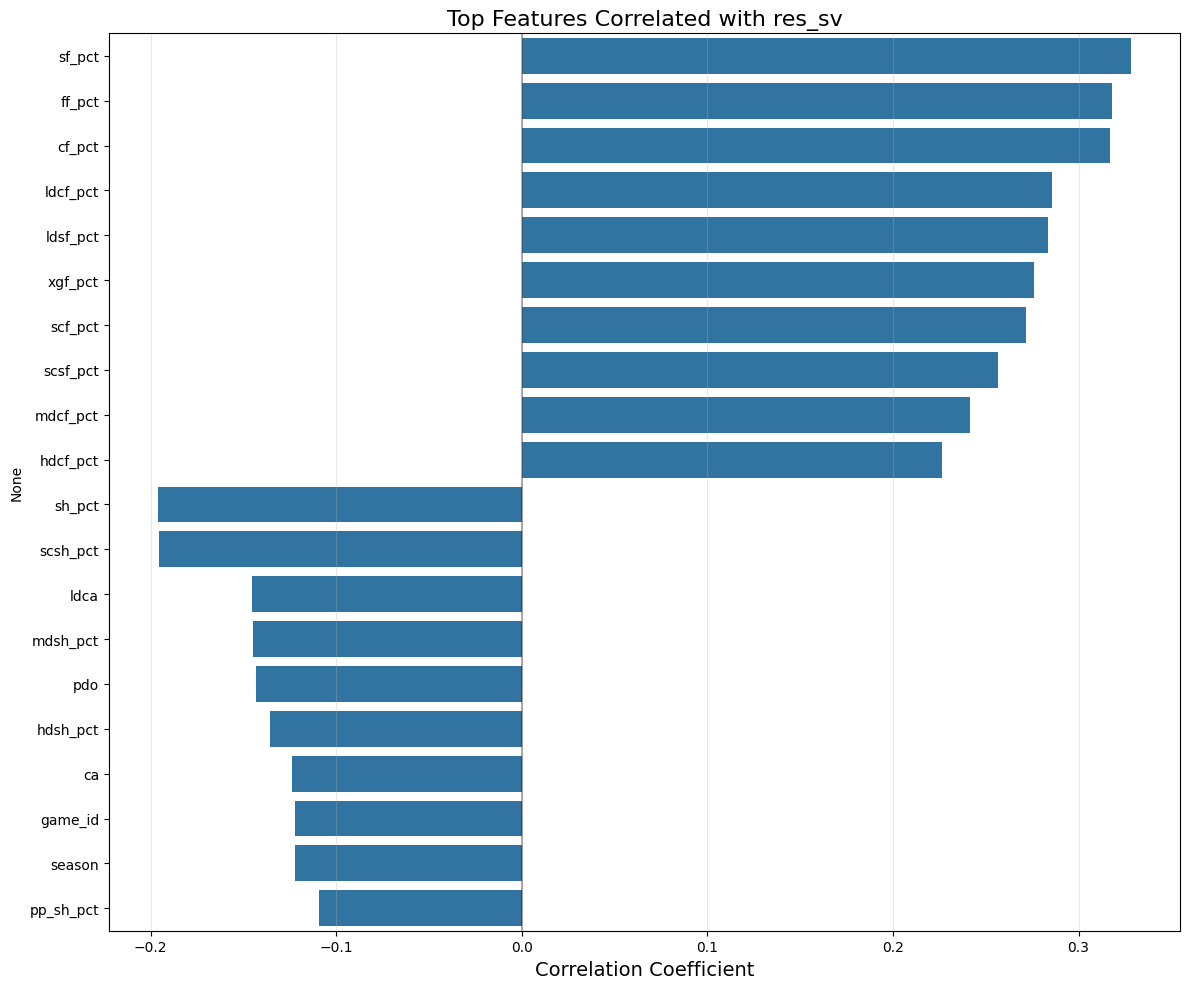

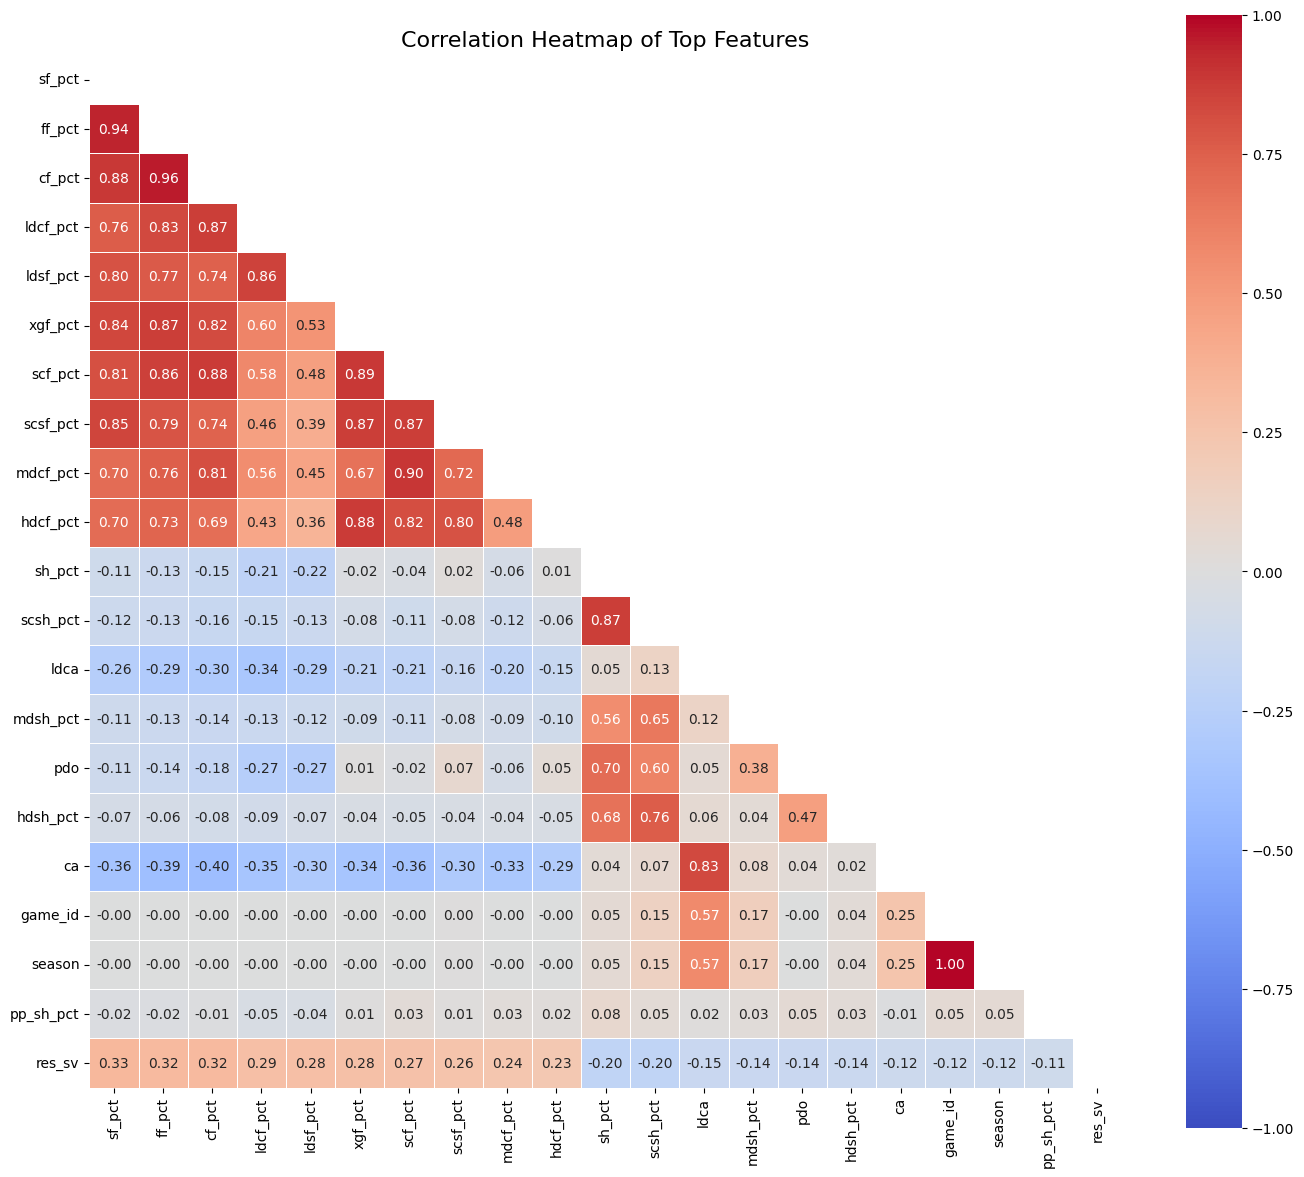


Checking for multicollinearity among top 10 positively correlated features:
          sf_pct  ff_pct  cf_pct  ldcf_pct  ldsf_pct  xgf_pct  scf_pct  \
sf_pct      1.00    0.94    0.88      0.76      0.80     0.84     0.81   
ff_pct      0.94    1.00    0.96      0.83      0.77     0.87     0.86   
cf_pct      0.88    0.96    1.00      0.87      0.74     0.82     0.88   
ldcf_pct    0.76    0.83    0.87      1.00      0.86     0.60     0.58   
ldsf_pct    0.80    0.77    0.74      0.86      1.00     0.53     0.48   
xgf_pct     0.84    0.87    0.82      0.60      0.53     1.00     0.89   
scf_pct     0.81    0.86    0.88      0.58      0.48     0.89     1.00   
scsf_pct    0.85    0.79    0.74      0.46      0.39     0.87     0.87   
mdcf_pct    0.70    0.76    0.81      0.56      0.45     0.67     0.90   
hdcf_pct    0.70    0.73    0.69      0.43      0.36     0.88     0.82   

          scsf_pct  mdcf_pct  hdcf_pct  
sf_pct        0.85      0.70      0.70  
ff_pct        0.79      0.

In [14]:
# First, let's identify numeric columns only
numeric_cols = processed_df.select_dtypes(include=['number']).columns.tolist()

# Make sure 'res_sv' is in the numeric columns
if 'res_sv' not in numeric_cols:
    print("Warning: 'res_sv' is not a numeric column. Please check your data.")
else:
    # Calculate correlations with the target variable (numeric columns only)
    correlations = processed_df[numeric_cols].corr()['res_sv'].sort_values(ascending=False)
    
    # Filter out any columns containing 'res' in their name
    filtered_correlations = correlations[~correlations.index.str.contains('res')]
    
    # Display the top correlations
    print("Top 15 features positively correlated with res_sv:")
    print(filtered_correlations.head(15))
    print("\nTop 15 features negatively correlated with res_sv:")
    print(filtered_correlations.tail(15).iloc[::-1])
    
    # Create a visualization of the top correlations
    plt.figure(figsize=(12, 10))
    
    # Combine top positive and negative correlations
    top_positive = filtered_correlations.head(10)
    top_negative = filtered_correlations.tail(10).iloc[::-1]
    
    # Handle case where we might have fewer than 10 features
    top_features = pd.concat([top_positive, top_negative])
    
    # Create a horizontal bar chart
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title('Top Features Correlated with res_sv', fontsize=16)
    plt.xlabel('Correlation Coefficient', fontsize=14)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Create a correlation heatmap for the top correlated features
    top_feature_names = top_features.index.tolist()
    if 'res_sv' not in top_feature_names:
        top_feature_names.append('res_sv')  # Add the target variable
    
    plt.figure(figsize=(14, 12))
    correlation_matrix = processed_df[top_feature_names].corr()
    mask = np.triu(correlation_matrix)
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
                mask=mask, vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
    plt.title('Correlation Heatmap of Top Features', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Optional: Check for multicollinearity among top features
    print("\nChecking for multicollinearity among top 10 positively correlated features:")
    top_pos_features = filtered_correlations.head(10).index.tolist()
    print(processed_df[top_pos_features].corr().round(2))

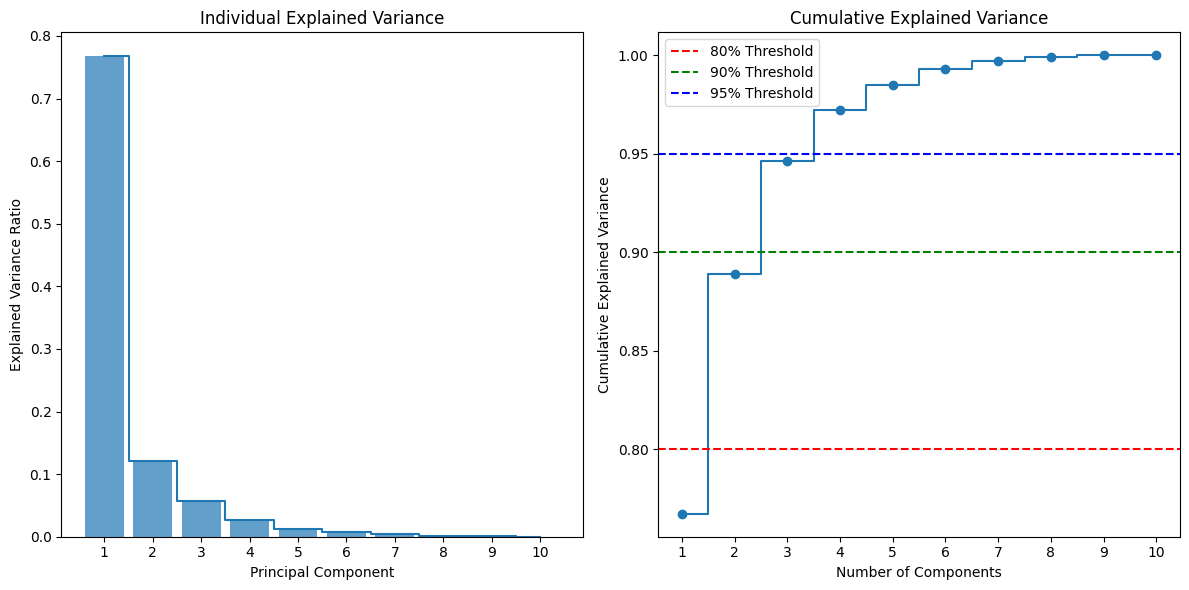

PC1: 0.7674 (0.7674 cumulative)
PC2: 0.1217 (0.8890 cumulative)
PC3: 0.0571 (0.9462 cumulative)
PC4: 0.0262 (0.9724 cumulative)
PC5: 0.0126 (0.9850 cumulative)
PC6: 0.0080 (0.9930 cumulative)
PC7: 0.0042 (0.9972 cumulative)
PC8: 0.0019 (0.9990 cumulative)
PC9: 0.0008 (0.9999 cumulative)
PC10: 0.0001 (1.0000 cumulative)
Components needed for 70.0% variance: 1
Components needed for 80.0% variance: 2
Components needed for 90.0% variance: 3
Components needed for 95.0% variance: 4


In [37]:
# Identify the correlated team stats
team_stats = ['sf_pct', 'ff_pct', 'cf_pct', 'ldcf_pct', 'ldsf_pct', 
              'xgf_pct', 'scf_pct', 'scsf_pct', 'mdcf_pct', 'hdcf_pct']

# Standardize the data first (important for PCA)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
team_stats_scaled = scaler.fit_transform(processed_df[team_stats])

# Create a PCA object with the maximum possible components
pca_full = PCA(n_components=len(team_stats))
pca_full.fit(team_stats_scaled)

# Get the explained variance ratio
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Create a plot to visualize the explained variance
plt.figure(figsize=(12, 6))

# Plot 1: Individual explained variance
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
plt.step(range(1, len(explained_variance) + 1), explained_variance, where='mid')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('Individual Explained Variance')
plt.xticks(range(1, len(explained_variance) + 1))

# Plot 2: Cumulative explained variance
plt.subplot(1, 2, 2)
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', marker='o')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Threshold')
plt.axhline(y=0.95, color='b', linestyle='--', label='95% Threshold')
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.xticks(range(1, len(cumulative_variance) + 1))

plt.tight_layout()
plt.show()

# Print the explained variance for each component
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.4f} cumulative)")

# Find the number of components needed for different thresholds
thresholds = [0.7, 0.8, 0.9, 0.95]
for threshold in thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"Components needed for {threshold*100}% variance: {n_components}")

In [27]:
processed_df

,game_date,game_id,home,team,gp,toi,point_pct,cf,ca,cf_pct,ff,fa,ff_pct,sf,sa,sf_pct,gf,ga,gf_pct,xgf,xga,xgf_pct,scf,sca,scf_pct,scsf,scsa,scsf_pct,scgf,scga,scgf_pct,scsh_pct,scsv_pct,hdcf,hdca,hdcf_pct,hdsf,hdsa,hdsf_pct,hdgf,hdga,hdgf_pct,hdsh_pct,hdsv_pct,mdcf,mdca,mdcf_pct,mdsf,mdsa,mdsf_pct,mdgf,mdga,mdgf_pct,mdsh_pct,mdsv_pct,ldcf,ldca,ldcf_pct,ldsf,ldsa,ldsf_pct,ldgf,ldga,ldgf_pct,ldsh_pct,ldsv_pct,sh_pct,sv_pct,pdo,pp_toi,pp_point_pct,pp_cf,pp_ca,pp_cf_pct,pp_ff,pp_fa,pp_ff_pct,pp_sf,pp_sa,pp_sf_pct,pp_gf,pp_ga,pp_gf_pct,pp_xgf,pp_xga,pp_xgf_pct,pp_scf,pp_sca,pp_scf_pct,pp_scsf,pp_scsa,pp_scsf_pct,pp_scgf,pp_scga,pp_scgf_pct,pp_scsh_pct,pp_scsv_pct,pp_hdcf,pp_hdca,pp_hdcf_pct,pp_hdsf,pp_hdsa,pp_hdsf_pct,pp_hdgf,pp_hdga,pp_hdgf_pct,pp_hdsh_pct,pp_hdsv_pct,pp_mdcf,pp_mdca,pp_mdcf_pct,pp_mdsf,pp_mdsa,pp_mdsf_pct,pp_mdgf,pp_mdga,pp_mdgf_pct,pp_mdsh_pct,pp_mdsv_pct,pp_ldcf,pp_ldca,pp_ldcf_pct,pp_ldsf,pp_ldsa,pp_ldsf_pct,pp_ldgf,pp_ldga,pp_ldgf_pct,pp_ldsh_pct,pp_ldsv_pct,pp_sh_pct,pp_sv_pct,pp_pdo,pk_toi,pk_point_pct,pk_cf,pk_ca,pk_cf_pct,pk_ff,pk_fa,pk_ff_pct,pk_sf,pk_sa,pk_sf_pct,pk_gf,pk_ga,pk_gf_pct,pk_xgf,pk_xga,pk_xgf_pct,pk_scf,pk_sca,pk_scf_pct,pk_scsf,pk_scsa,pk_scsf_pct,pk_scgf,pk_scga,pk_scgf_pct,pk_scsh_pct,pk_scsv_pct,pk_hdcf,pk_hdca,pk_hdcf_pct,pk_hdsf,pk_hdsa,pk_hdsf_pct,pk_hdgf,pk_hdga,pk_hdgf_pct,pk_hdsh_pct,pk_hdsv_pct,pk_mdcf,pk_mdca,pk_mdcf_pct,pk_mdsf,pk_mdsa,pk_mdsf_pct,pk_mdgf,pk_mdga,pk_mdgf_pct,pk_mdsh_pct,pk_mdsv_pct,pk_ldcf,pk_ldca,pk_ldcf_pct,pk_ldsf,pk_ldsa,pk_ldsf_pct,pk_ldgf,pk_ldga,pk_ldgf_pct,pk_ldsh_pct,pk_ldsv_pct,pk_sh_pct,pk_sv_pct,pk_pdo,b2b,opp_b2b,last_game_date,season,goalie_name,goalie_team,goalie_id,g_sa_roll_avg,g_sa_roll_std,g_sv_pct_roll_avg,g_sv_pct_roll_std,g_gaa_roll_avg,g_gaa_roll_std,g_gsaa_roll_avg,g_gsaa_roll_std,g_xg_against_roll_avg,g_xg_against_roll_std,g_hd_sa_roll_avg,g_hd_sa_roll_std,g_hdsv_pct_roll_avg,g_hdsv_pct_roll_std,g_md_sa_roll_avg,g_md_sa_roll_std,g_mdsv_pct_roll_avg,g_mdsv_pct_roll_std,g_ld_sa_roll_avg,g_ld_sa_roll_std,g_ldsv_pct_roll_avg,g_ldsv_pct_roll_std,g_rest,g_l7,res_sv,res_sa,res_sv_pct,res_ga,res_des,res_toi,comp_cf,comp_ff,comp_sf,comp_xgf,comp_hdcf,comp_scf
0,2022-10-07,2022020001,False,SJS,10,46.158,0.500,434,432,50.115,329,326,50.229,227,250,47.589,20,28,41.667,18.78,18.97,49.748,222,202,52.358,127,137,48.106,16,23,41.026,12.598,83.212,84,77,52.174,56,64,46.667,9,13,40.909,16.071,79.688,138,125,52.471,71,73,49.306,7,10,41.176,9.859,86.301,201,222,47.518,90,106,45.918,4,5,44.444,4.444,95.283,8.811,88.800,0.976,5.743,0.500,110.0,11.0,90.909,82.0,8.0,91.111,52.0,6.0,89.655,9.0,1.0,90.000,7.91,1.04,88.380,65.0,9.0,87.838,35.0,5.0,87.500,8.0,1.0,88.889,22.857,80.000,26.0,3.0,89.655,17.0,1.0,94.444,5.0,0.0,100.0,29.412,100.0,39.0,6.0,86.667,18.0,4.0,81.818,3.0,1.0,75.000,16.667,75.000,53.0,1.0,98.148,17.0,0.0,100.000,1.0,0.0,100.000,5.882,NaN,17.308,83.333,1.006,5.753,0.500,7.0,112.0,5.882,4.0,88.0,4.348,2.0,65.0,2.985,0.0,10.0,0.000,0.05,8.65,0.575,1.0,61.0,1.613,0.0,37.0,0.000,0.0,8.0,0.000,NaN,78.378,0.0,21.0,0.000,0.0,15.0,0.000,0.0,3.0,0.000,NaN,80.000,1.0,40.0,2.439,0.0,22.0,0.000,0.0,5.0,0.0,NaN,77.273,1.0,59.0,1.667,0.0,28.0,0.000,0.0,2.0,0.0,NaN,92.857,0.000,84.615,0.846,0,0,2022-10-07,20222023,James Reimer,SJS,8473503,21.8,6.876692,0.8994,0.058998,2.800,1.681481,-0.199,1.110620,1.846,0.702665,4.7,2.869379,0.850900,0.164180,6.0,3.055050,0.8305,0.133881,9.9,3.212822,0.974700,0.059408,4.0,2.0,28.0,31.0,0.903,3.0,L,58:42,9.557013,7.198113,4.873903,0.463801,1.907934,4.995317
1,2022-10-07,2022020001,True,NSH,11,49.640,0.409,481,519,48.100,362,362,50.000,257,254,50.294,21,24,46.667,20.77,21.92,48.653,230,254,47.521,125,137,47.710,18,20,47.368,14.400,85.401,84,106,44.211,54,64,45.763,11,9,55.000,20.370,85.938,146,148,49.660,71,73,49.306,7,11,38.889,9.859,84.932,255,279,47.753,121,104,53.778,3,4,42.857,2.479,96.154,8.171,90.551,0.987,3.306,0.409,63.0,14.0,81.818,50.0,12.0,80.645,39.0,9.0,81.250,4.0,1.0,80.000,4.62,0.58,88.846,35.0,6.0,85.366,22.0

In [26]:
processed_df['comp_cf'] = (processed_df['cf']+processed_df['pp_cf']+processed_df['pk_cf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
processed_df['comp_ff'] = (processed_df['ff']+processed_df['pp_ff']+processed_df['pk_ff'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
processed_df['comp_sf'] = (processed_df['sf']+processed_df['pp_sf']+processed_df['pk_sf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
processed_df['comp_xgf'] = (processed_df['xgf']+processed_df['pp_xgf']+processed_df['pk_xgf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
processed_df['comp_hdcf'] = (processed_df['hdcf']+processed_df['pp_hdcf']+processed_df['pk_hdcf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
processed_df['comp_scf'] = (processed_df['scf']+processed_df['pp_scf']+processed_df['pk_scf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])


In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert game_date to datetime and sort
processed_df['game_date'] = pd.to_datetime(processed_df['game_date'])
processed_df = processed_df.sort_values('game_date')

# Define features and target
# Exclude all columns containing "res" from features and also exclude datetime columns
res_columns = [col for col in processed_df.columns if "res" in col]
X = processed_df.drop(columns=res_columns + ['game_date'])  # Add 'game_date' to columns to drop
y = processed_df["res_sv"]

# Train-test split (time-based)
split_date = processed_df['game_date'].max() - pd.Timedelta(days=45)
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train initial Random Forest
rf_fs = RandomForestRegressor(n_estimators=100, random_state=42)
rf_fs.fit(X_train_scaled, y_train)

# Feature importance ranking
feature_importances = np.array(rf_fs.feature_importances_)
feature_names = np.array(X_train.columns)
sorted_idx = np.argsort(feature_importances)[::-1]

# Try different feature set sizes (5, 10, 15, all features)
best_r2 = -np.inf
best_features = None

for num_features in [5, 10, 15, len(features)]:
    top_features = feature_names[sorted_idx[:num_features]]
    
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]

    # Scale again after feature selection
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # Train a new model with the selected features
    rf_model = RandomForestRegressor(
        n_estimators=500, max_depth=10, bootstrap=True,
        max_features='sqrt', min_samples_leaf=4, min_samples_split=10,
        random_state=42
    )
    rf_model.fit(X_train_scaled, y_train)
    y_pred = rf_model.predict(X_test_scaled)

    # Evaluate performance
    r2 = r2_score(y_test, y_pred)
    
    # Keep track of the best feature set
    if r2 > best_r2:
        best_r2 = r2
        best_features = top_features

print(f"Best R² Score: {best_r2:.4f} using features: {best_features}")

# Final model with best features
X_train_selected = X_train[best_features]
X_test_selected = X_test[best_features]
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

# Final Evaluation
metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'feature_importance': dict(zip(best_features, rf_model.feature_importances_))
}

# Visualization (unchanged)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Time series plot
axes[0, 0].plot(processed_df[test_mask]['game_date'], y_test, 'b.', label='Actual', alpha=0.5)
axes[0, 0].plot(processed_df[test_mask]['game_date'], y_pred, 'r.', label='Predicted', alpha=0.5)
axes[0, 0].set_title('Actual vs Predicted Saves Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Saves')
axes[0, 0].legend()

# 2. Scatter plot with regression line
axes[0, 1].scatter(y_test, y_pred, alpha=0.5)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Saves')
axes[0, 1].set_ylabel('Predicted Saves')
axes[0, 1].set_title('Prediction Scatter Plot')
axes[0, 1].legend()

# 3. Error distribution
errors = y_pred - y_test
sns.histplot(errors, kde=True, ax=axes[1, 0])
axes[1, 0].axvline(x=0, color='r', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Prediction Error Distribution')
axes[1, 0].set_xlabel('Prediction Error (Predicted - Actual)')
axes[1, 0].set_ylabel('Count')

# Metrics Text
metrics_text = f'R² Score: {metrics["r2_score"]:.3f}\nMAE: {metrics["mae"]:.3f}\nRMSE: {metrics["rmse"]:.3f}'
fig.text(0.02, 0.02, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print error statistics
print("\nError Statistics:")
print(f"Mean Error: {errors.mean():.3f}")
print(f"Error Std Dev: {errors.std():.3f}")
print(f"Error Range: [{errors.min():.3f}, {errors.max():.3f}]")


ValueError: could not convert string to float: 'SJS'

Training data from 0 to 5485
Testing data from 5486 to 6123


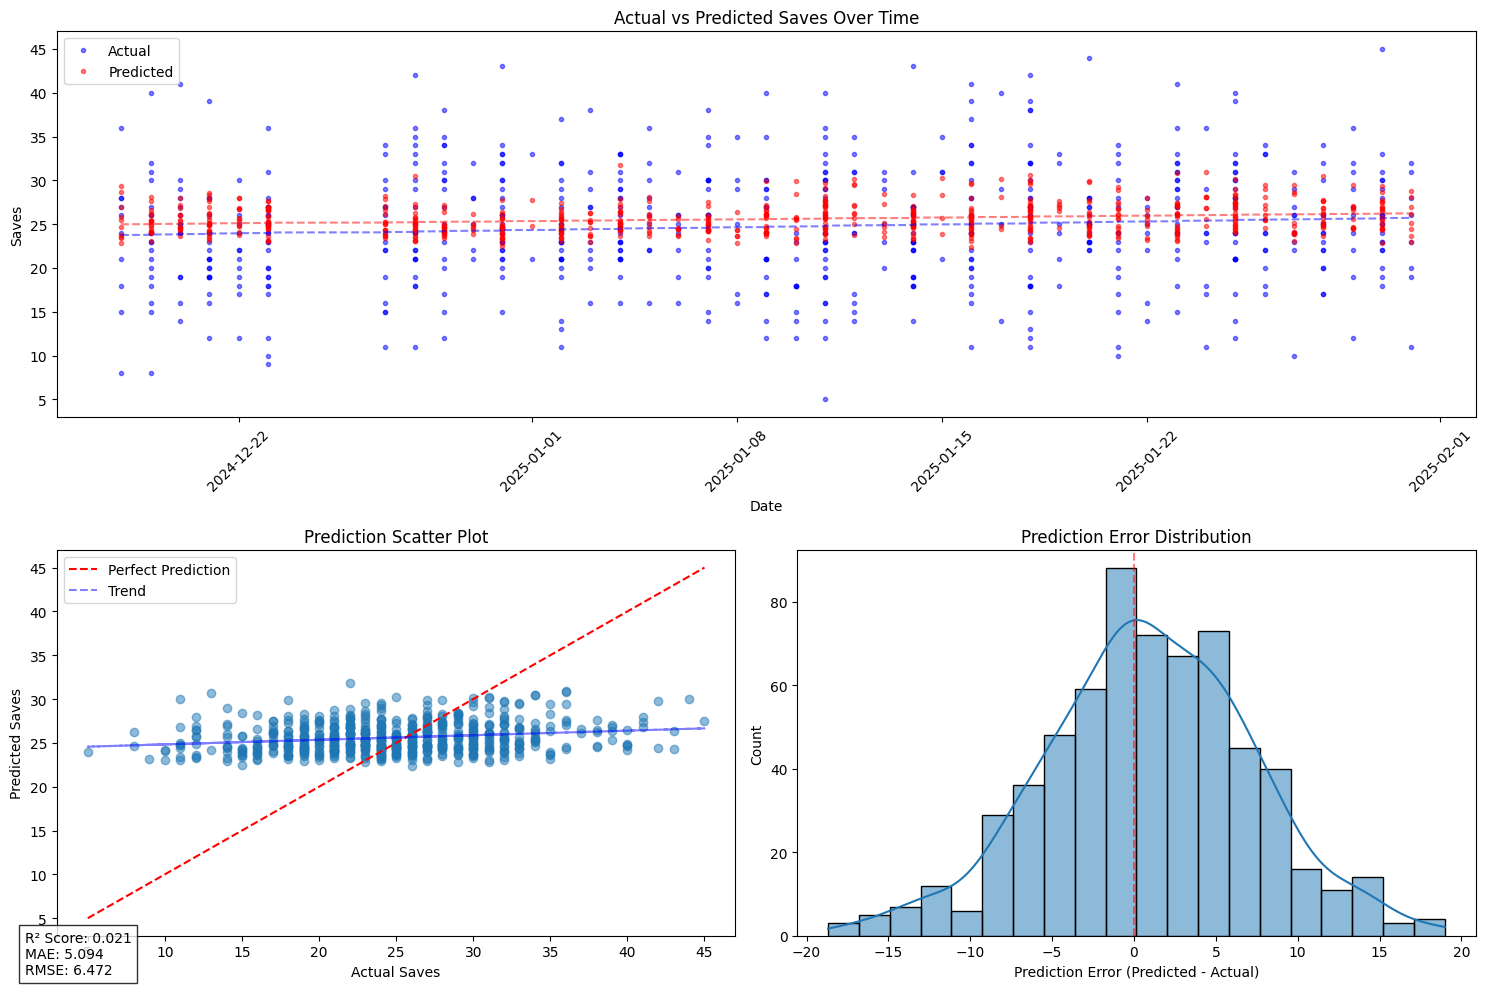


Error Statistics:
Mean Error: 0.871
Error Std Dev: 6.419
Error Range: [-18.685, 18.984]


In [32]:
"""Train the model on historical goalie data and return evaluation metrics"""
# Convert game_date to datetime and sort
processed_df['game_date'] = pd.to_datetime(processed_df['game_date'])
processed_df = processed_df.sort_values('game_date')

# Define base features without team dummies
features = [
    'home', #'b2b', 'opp_b2b',
    'g_gsaa_roll_avg', 'g_sa_roll_avg', 'g_sa_roll_std',
    'g_sv_pct_roll_avg', 'g_sv_pct_roll_std',
    'g_hdsv_pct_roll_avg', 'g_mdsv_pct_roll_avg',
    'g_l7', 'g_rest',
    'comp_cf', 'comp_ff', 'comp_sf', 'comp_xgf', 'comp_hdcf', 'comp_scf'
    # 'comp_ff'
]

# Instead of random split, use time-based split
split_date = processed_df['game_date'].max() - pd.Timedelta(days=45)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

# Create team dummies and add them to the feature set
X = processed_df[features].copy()
# team_dummies = pd.get_dummies(processed_df['team'], prefix='team')
# X = pd.concat([X, team_dummies], axis=1)

# Split into train and test sets
X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_sv']
y_test = processed_df[test_mask]['res_sv']

print(f"Training data from {X_train.index.min()} to {X_train.index.max()}")
print(f"Testing data from {X_test.index.min()} to {X_test.index.max()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    bootstrap=True,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test_scaled)

# Calculate evaluation metrics
metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'feature_importance': dict(zip(X_train.columns, rf_model.feature_importances_))
}

# Create a figure with multiple subplots
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2)

# 1. Time series plot (improved version)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(processed_df[test_mask]['game_date'], y_test, 'b.', label='Actual', alpha=0.5)
ax1.plot(processed_df[test_mask]['game_date'], y_pred, 'r.', label='Predicted', alpha=0.5)
# Add trend lines
ax1.plot(processed_df[test_mask]['game_date'], 
         np.poly1d(np.polyfit(range(len(y_test)), y_test, 1))(range(len(y_test))), 
         'b--', alpha=0.5)
ax1.plot(processed_df[test_mask]['game_date'], 
         np.poly1d(np.polyfit(range(len(y_pred)), y_pred, 1))(range(len(y_pred))), 
         'r--', alpha=0.5)
ax1.set_title('Actual vs Predicted Saves Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Saves')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# 2. Scatter plot with regression line
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
ax2.plot(y_test, p(y_test), "b--", alpha=0.5, label='Trend')
ax2.set_xlabel('Actual Saves')
ax2.set_ylabel('Predicted Saves')
ax2.set_title('Prediction Scatter Plot')
ax2.legend()

# 3. Error distribution
ax3 = fig.add_subplot(gs[1, 1])
errors = y_pred - y_test
sns.histplot(errors, kde=True, ax=ax3)
ax3.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax3.set_title('Prediction Error Distribution')
ax3.set_xlabel('Prediction Error (Predicted - Actual)')
ax3.set_ylabel('Count')

# Add metrics text box
metrics_text = f'R² Score: {metrics["r2_score"]:.3f}\nMAE: {metrics["mae"]:.3f}\nRMSE: {metrics["rmse"]:.3f}'
fig.text(0.02, 0.02, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print additional statistical information
print("\nError Statistics:")
print(f"Mean Error: {errors.mean():.3f}")
print(f"Error Std Dev: {errors.std():.3f}")
print(f"Error Range: [{errors.min():.3f}, {errors.max():.3f}]")

Training set size: 7870 rows (90.0%)
Test set size: 876 rows (10.0%)
Training Random Forest model...

Model Performance:
Training RMSE: 5.1051
Training R² Score: 0.5088
Test RMSE: 6.4706
Test R² Score: 0.0045
Test MAE: 5.1307

Total execution time: 0.39 seconds

Feature importance:
          feature  importance
8   team_stat_pc1    0.265752
3              sf    0.149841
9   team_stat_pc2    0.130492
5          pp_toi    0.119194
10  team_stat_pc3    0.112322
4           pp_sf    0.102864
7          g_rest    0.056234
6            g_l7    0.024676
0            home    0.019759
1             b2b    0.009606
2         opp_b2b    0.009260


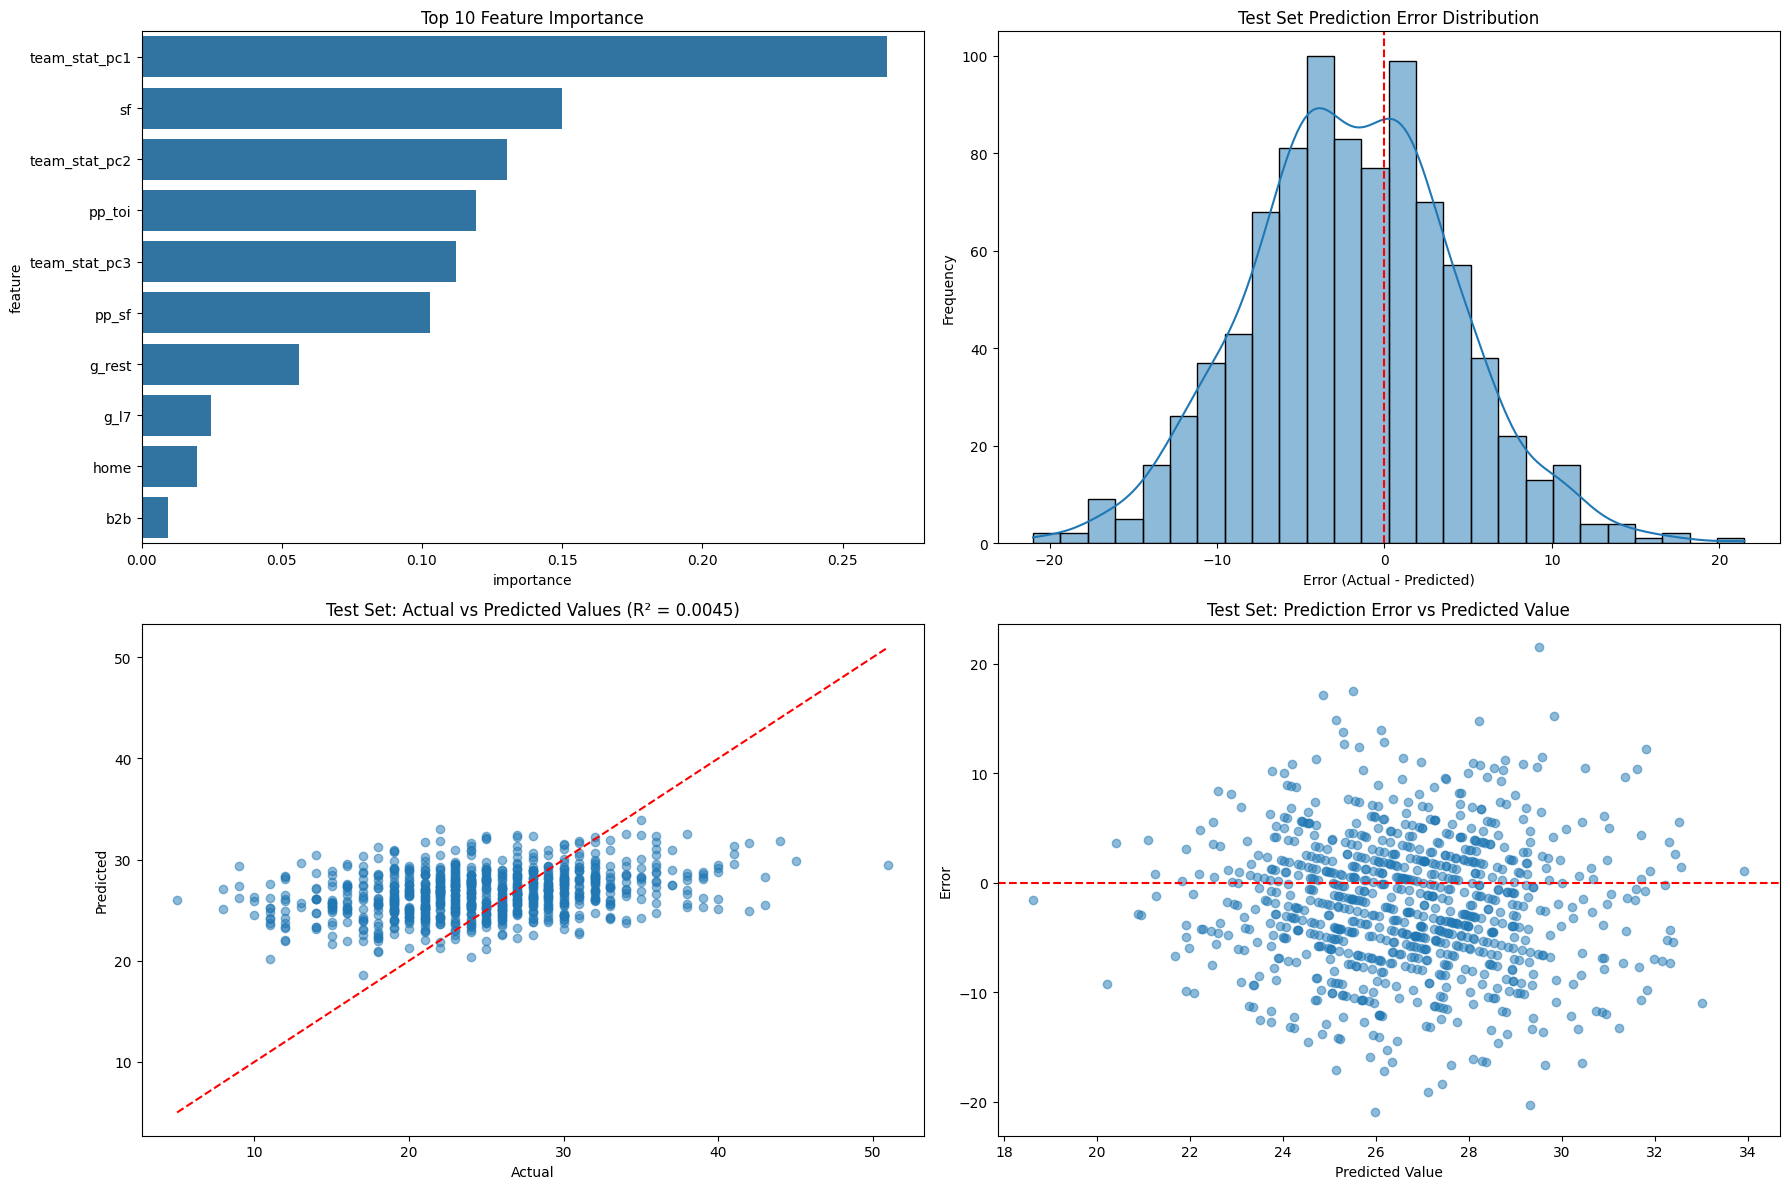


Test set error statistics:
Mean error: -1.9926
Median error: -2.0343
Standard deviation of error: 6.1597
Min error: -20.9828
Max error: 21.4980


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Start timing
start_time = time.time()

# Identify the correlated team stats
team_stats = ['sf_pct', 'ff_pct', 'cf_pct', 'ldcf_pct', 'ldsf_pct', 
              'xgf_pct', 'scf_pct', 'scsf_pct', 'mdcf_pct', 'hdcf_pct']

# Apply PCA to reduce dimensions while preserving information
pca = PCA(n_components=3)  # Reduce to 3 components
team_stats_pca = pca.fit_transform(processed_df[team_stats])

# Create a DataFrame with the PCA components
pca_df = pd.DataFrame(
    team_stats_pca, 
    columns=['team_stat_pc1', 'team_stat_pc2', 'team_stat_pc3']
)

# Combine with other features
other_features = [
    'home', 'b2b', 'opp_b2b',
    # 'g_gsaa_roll_avg', 'g_sa_roll_avg', 'g_sa_roll_std',
    # 'g_sv_pct_roll_avg', 'g_sv_pct_roll_std',
    # 'g_hdsv_pct_roll_avg', 'g_mdsv_pct_roll_avg',
    'sf', 'pp_sf', 'pp_toi',
    'g_l7', 'g_rest'
]

# Create new feature set with PCA components
X_with_pca = pd.concat([processed_df[other_features].reset_index(drop=True), 
                        pca_df.reset_index(drop=True)], axis=1)

# Prepare the data
X = X_with_pca
y = processed_df['res_sv']

# Handle missing values
X = X.fillna(X.mean())

# Option 1: Random train-test split (if your data doesn't have a time component)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Option 2: Time-based split (similar to your XGBoost model)
# Uncomment these lines if you prefer a time-based split
# For a larger time-based split (e.g., last 60-90 days)
split_date = processed_df['game_date'].max() - pd.Timedelta(days=90)  # Adjust as needed

# Check the size of the resulting split
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

# Print split sizes to verify
print(f"Training set size: {sum(train_mask)} rows ({sum(train_mask)/len(processed_df)*100:.1f}%)")
print(f"Test set size: {sum(test_mask)} rows ({sum(test_mask)/len(processed_df)*100:.1f}%)")

# If the split looks good, proceed with it
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Random Forest model with reasonable default parameters
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1  # Use all available cores
)

print("Training Random Forest model...")
rf_model.fit(X_train_scaled, y_train)

# Calculate predictions and performance metrics for training data
y_train_pred = rf_model.predict(X_train_scaled)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Calculate predictions and performance metrics for test data
y_test_pred = rf_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\nModel Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training R² Score: {train_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R² Score: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Calculate prediction errors on test set
test_errors = y_test - y_test_pred

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

# Define the features list to match what was actually used in the model
features = other_features + ['team_stat_pc1', 'team_stat_pc2', 'team_stat_pc3']

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature importance:")
print(feature_importance)

# Create a figure with multiple subplots
plt.figure(figsize=(18, 12))

# Plot 1: Feature importance
plt.subplot(2, 2, 1)
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance')

# Plot 2: Prediction Error Distribution
plt.subplot(2, 2, 2)
sns.histplot(test_errors, kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Test Set Prediction Error Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')

# Plot 3: Actual vs Predicted
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Test Set: Actual vs Predicted Values (R² = {test_r2:.4f})')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Plot 4: Error vs Predicted
plt.subplot(2, 2, 4)
plt.scatter(y_test_pred, test_errors, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Test Set: Prediction Error vs Predicted Value')
plt.xlabel('Predicted Value')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

# Print error statistics for test set
print("\nTest set error statistics:")
print(f"Mean error: {test_errors.mean():.4f}")
print(f"Median error: {np.median(test_errors):.4f}")
print(f"Standard deviation of error: {test_errors.std():.4f}")
print(f"Min error: {test_errors.min():.4f}")
print(f"Max error: {test_errors.max():.4f}")


Total number of parameter combinations: 16
Total number of fits: 48

Starting grid search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample

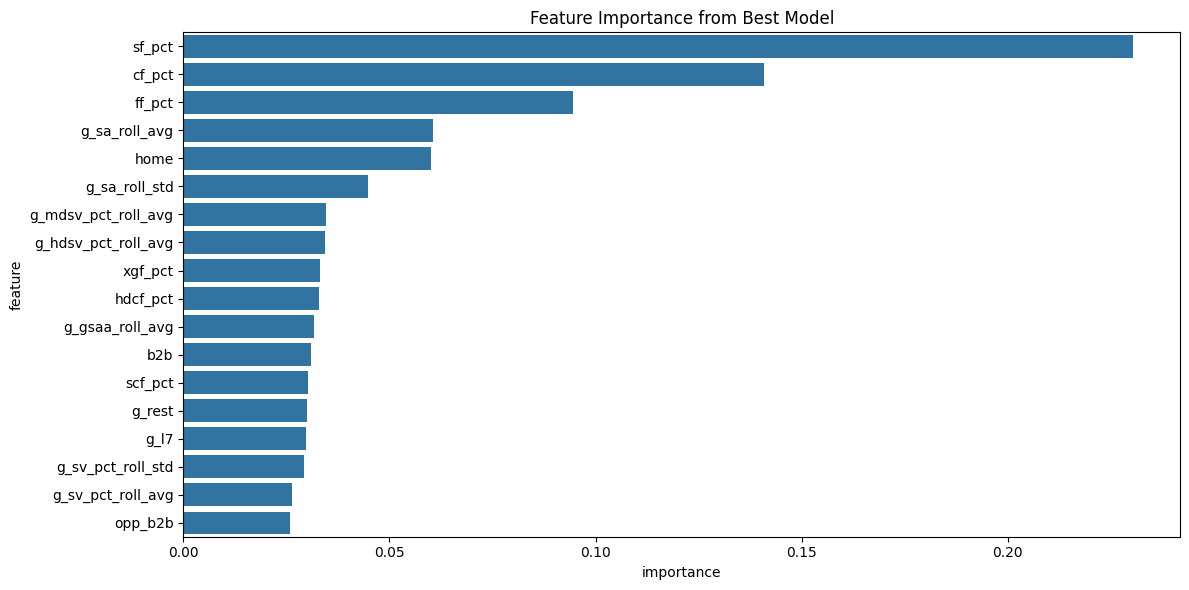

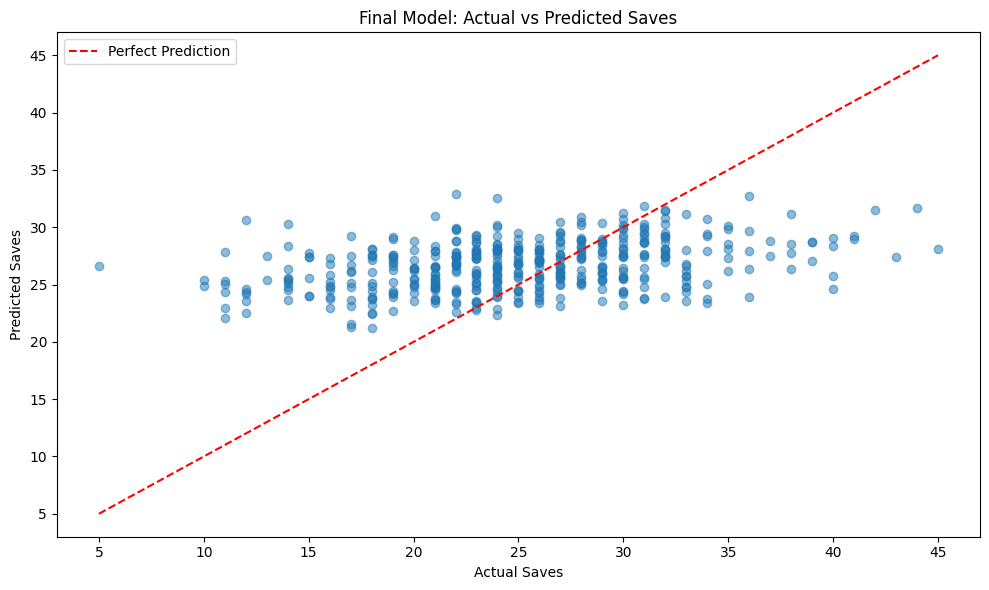

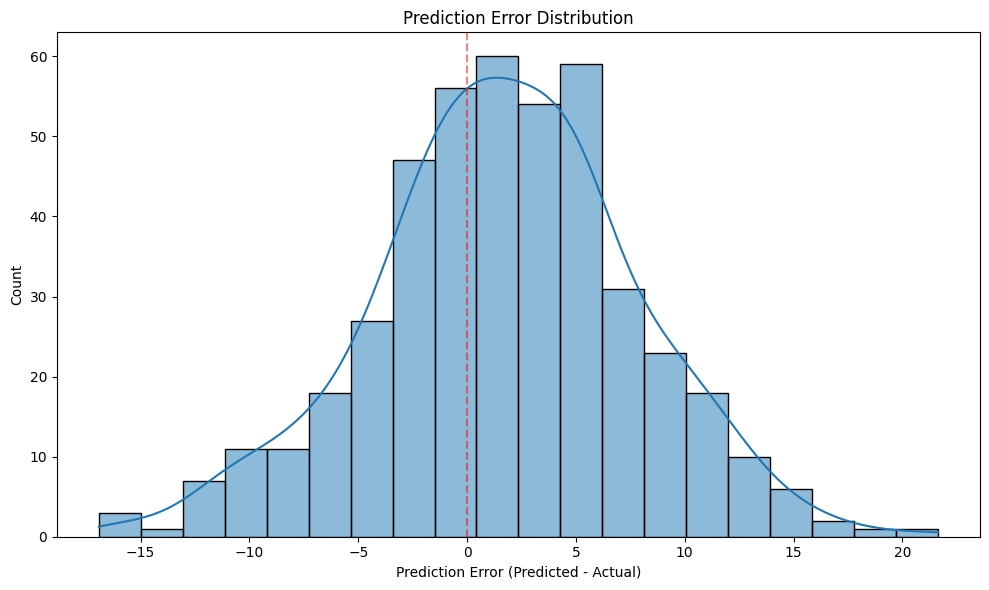


Total execution time: 3.09 seconds


In [8]:
# Import XGBoost
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import time

# Start timing
start_time = time.time()

# Define features (using the comprehensive set that performed well)
features = [
    'home', 'b2b', 'opp_b2b',
    'g_gsaa_roll_avg', 'g_sa_roll_avg', 'g_sa_roll_std',
    'g_sv_pct_roll_avg', 'g_sv_pct_roll_std',
    'g_hdsv_pct_roll_avg', 'g_mdsv_pct_roll_avg',
    'g_l7', 'g_rest',
    'ff_pct', 'cf_pct', 'sf_pct', 'xgf_pct', 'hdcf_pct', 'scf_pct'
]

# Prepare the data
X = processed_df[features].copy()
y = processed_df['res_sv']

# Handle missing values
X = X.fillna(X.mean())

# Define train/test split based on time
split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_sv']
y_test = processed_df[test_mask]['res_sv']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a more focused parameter grid to reduce computation time
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [1.0]
}

# Initialize the model without early stopping
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)  # Reduced from 5 to 3 for faster execution

# Calculate and print total number of combinations
n_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal number of parameter combinations: {n_combinations}")
print(f"Total number of fits: {n_combinations * 3}")  # 3 is the number of CV splits

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

print("\nStarting grid search...")
# Actually run the grid search
grid_search.fit(X_train_scaled, y_train)

# Print results
print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nBest score:")
print(f"RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

# Train final model with best parameters and early stopping
final_model = xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=42,
    early_stopping_rounds=20
)

# Fit final model with validation set for early stopping
final_model.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

# Make predictions
y_pred = final_model.predict(X_test_scaled)

# Calculate metrics
final_metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred))
}

print("\nFinal Model Metrics:")
print(f"R² Score: {final_metrics['r2_score']:.3f}")
print(f"MAE: {final_metrics['mae']:.3f}")
print(f"RMSE: {final_metrics['rmse']:.3f}")

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Best Model')
plt.tight_layout()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Saves')
plt.ylabel('Predicted Saves')
plt.title('Final Model: Actual vs Predicted Saves')
plt.legend()
plt.tight_layout()
plt.show()

# Plot prediction errors
errors = y_pred - y_test
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

Training set size: 8300 samples
Test set size: 446 samples
Training voting ensemble model...

===== Model Evaluation Metrics =====

----- Regression Performance -----
R² Score: 0.0746
Explained Variance: 0.1364
Mean Absolute Error: 4.9195 saves
Median Absolute Error: 4.0536 saves
Root Mean Squared Error: 6.2651 saves
Maximum Error: 21.2999 saves

----- Error Distribution -----
Mean Error: 1.6199 saves
Error Standard Deviation: 6.0521
Error Skewness: -0.0610
Error Kurtosis: 0.2010
Normality Test p-value: 0.5382

----- Error Percentiles -----
Min Error: -16.6068 saves
25th Percentile: -2.0897 saves
Median Error: 1.5674 saves
75th Percentile: 5.4000 saves
Max Error: 21.2999 saves
Interquartile Range: 7.4897 saves

----- Prediction Accuracy -----
Predictions within ±1 saves: 13.68%
Predictions within ±2 saves: 27.13%
Predictions within ±3 saves: 39.01%
Predictions within ±5 saves: 60.54%


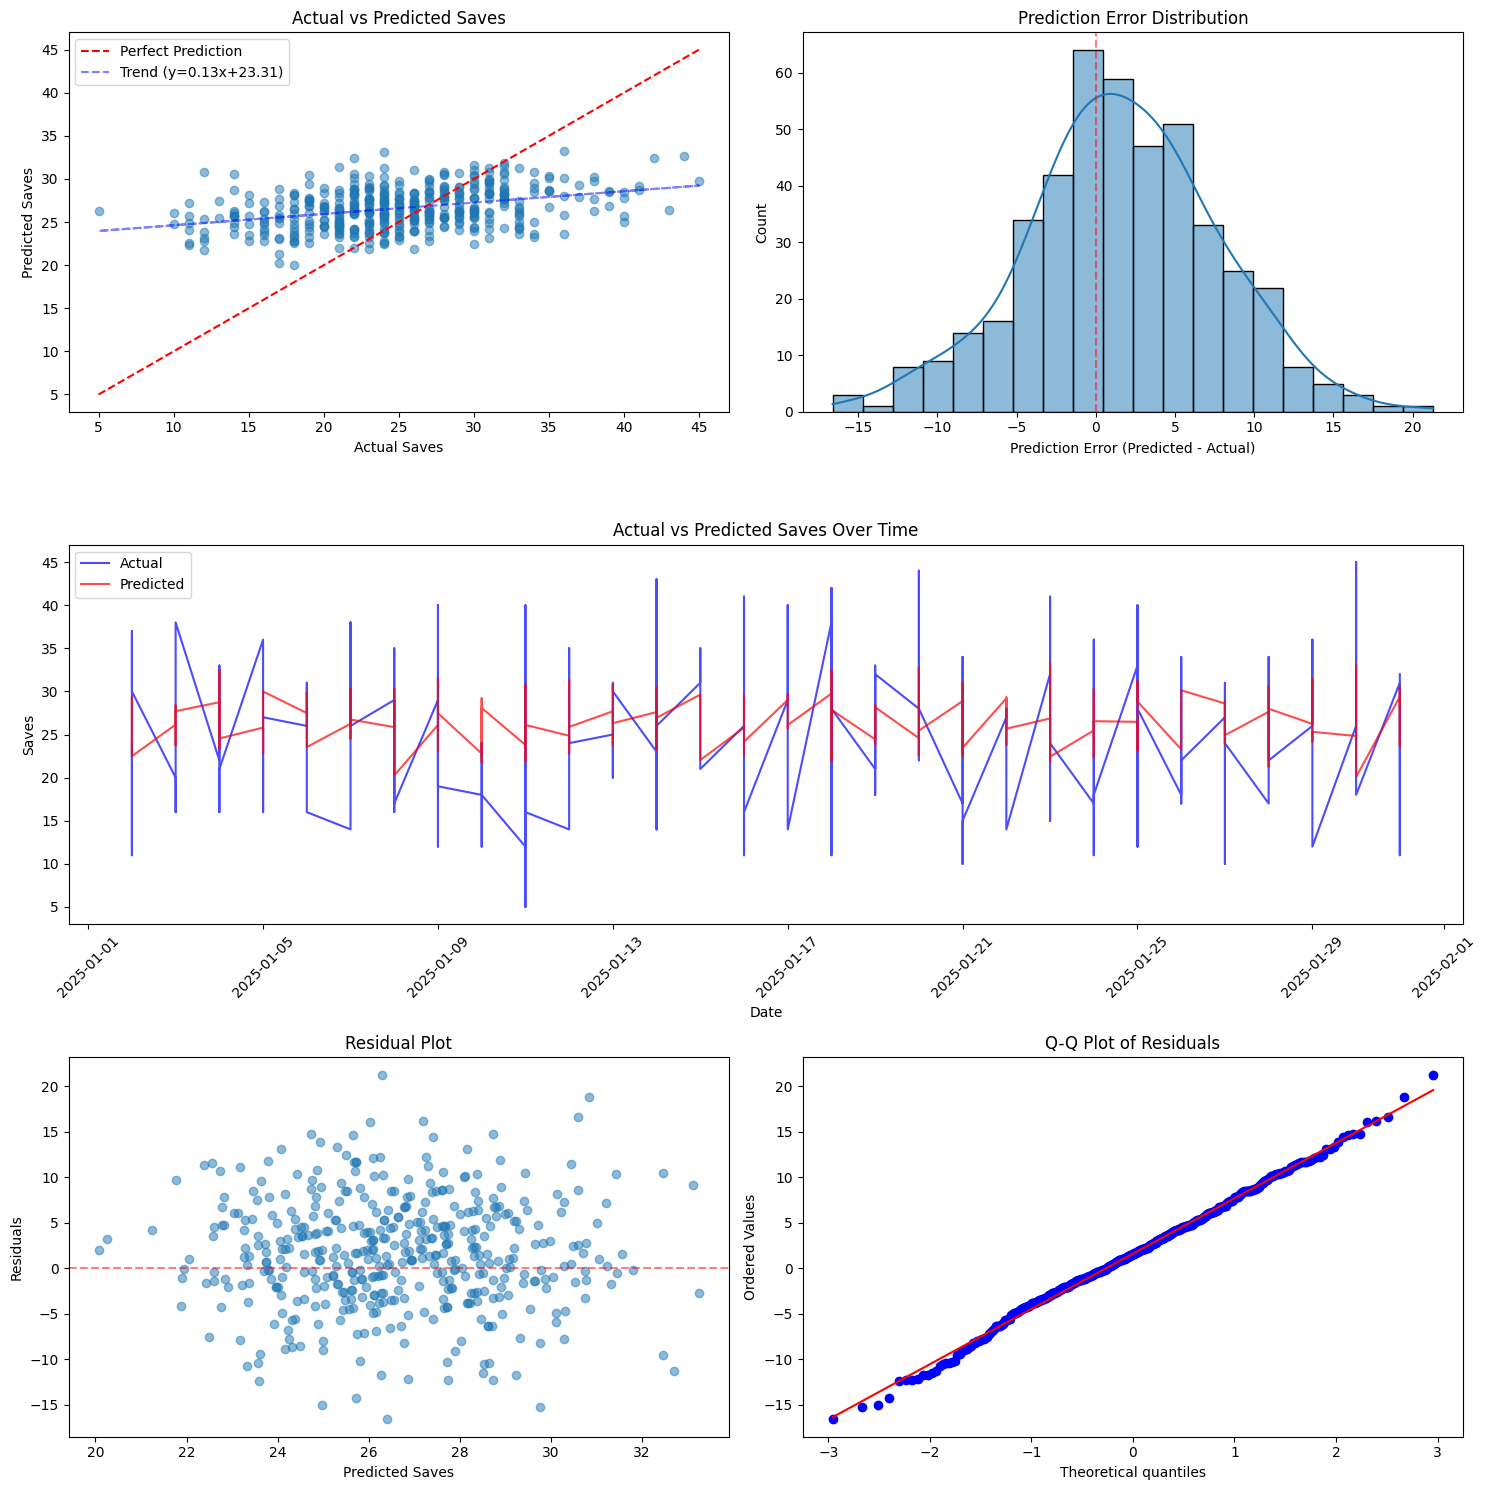

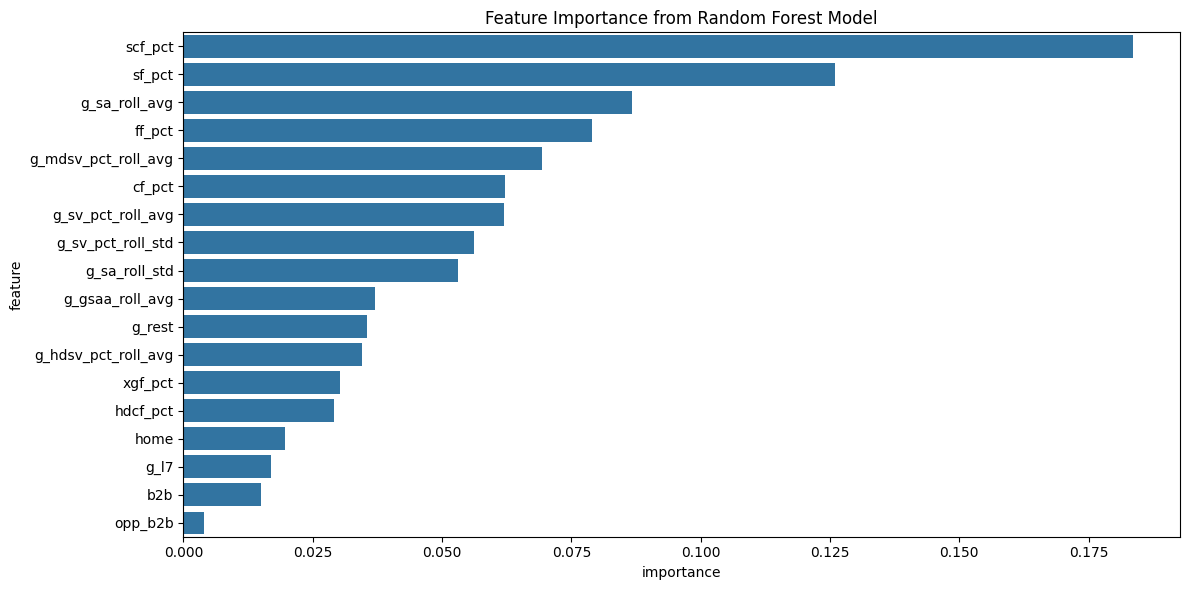


Total execution time: 10.59 seconds


In [29]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score, median_absolute_error, max_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats

# Start timing
start_time = time.time()

# Define features (using the comprehensive set that performed well)
features = [
    'home', 'b2b', 'opp_b2b',
    'g_gsaa_roll_avg', 'g_sa_roll_avg', 'g_sa_roll_std',
    'g_sv_pct_roll_avg', 'g_sv_pct_roll_std',
    'g_hdsv_pct_roll_avg', 'g_mdsv_pct_roll_avg',
    'g_l7', 'g_rest',
    'ff_pct', 'cf_pct', 'sf_pct', 'xgf_pct', 'hdcf_pct', 'scf_pct'
]

# Prepare the data
X = processed_df[features].copy()
y = processed_df['res_sv']

# Handle missing values
X = X.fillna(X.mean())

# Define train/test split based on time
split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_sv']
y_test = processed_df[test_mask]['res_sv']

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Create base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=500, max_depth=10, bootstrap=True, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)),
    ('ridge', Ridge(alpha=1.0, random_state=42)),
    ('lasso', Lasso(alpha=0.01, random_state=42)),
    ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42))
]

# Create voting ensemble (simpler than stacking)
voting_model = VotingRegressor(
    estimators=base_models,
    weights=[0.3, 0.3, 0.2, 0.1, 0.1]  # Giving more weight to tree-based models
)

# Create pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', voting_model)
])

# Train the model
print("Training voting ensemble model...")
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate comprehensive metrics
metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'explained_variance': explained_variance_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'median_ae': median_absolute_error(y_test, y_pred),
    'mse': mean_squared_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'max_error': max_error(y_test, y_pred),
    'mean_error': np.mean(y_pred - y_test),
    'std_error': np.std(y_pred - y_test)
}

# Calculate additional statistical metrics
errors = y_pred - y_test
metrics.update({
    'error_skewness': stats.skew(errors),
    'error_kurtosis': stats.kurtosis(errors),
    'error_normality_pvalue': stats.normaltest(errors)[1],
    'error_min': np.min(errors),
    'error_max': np.max(errors),
    'error_q1': np.percentile(errors, 25),
    'error_median': np.median(errors),
    'error_q3': np.percentile(errors, 75),
    'error_iqr': np.percentile(errors, 75) - np.percentile(errors, 25)
})

# Calculate percentage of predictions within different error margins
for margin in [1, 2, 3, 5]:
    metrics[f'within_{margin}_saves'] = np.mean(np.abs(errors) <= margin) * 100

# Print metrics in a formatted table
print("\n===== Model Evaluation Metrics =====")
print("\n----- Regression Performance -----")
print(f"R² Score: {metrics['r2_score']:.4f}")
print(f"Explained Variance: {metrics['explained_variance']:.4f}")
print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
print(f"Median Absolute Error: {metrics['median_ae']:.4f} saves")
print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
print(f"Maximum Error: {metrics['max_error']:.4f} saves")

print("\n----- Error Distribution -----")
print(f"Mean Error: {metrics['mean_error']:.4f} saves")
print(f"Error Standard Deviation: {metrics['std_error']:.4f}")
print(f"Error Skewness: {metrics['error_skewness']:.4f}")
print(f"Error Kurtosis: {metrics['error_kurtosis']:.4f}")
print(f"Normality Test p-value: {metrics['error_normality_pvalue']:.4f}")

print("\n----- Error Percentiles -----")
print(f"Min Error: {metrics['error_min']:.4f} saves")
print(f"25th Percentile: {metrics['error_q1']:.4f} saves")
print(f"Median Error: {metrics['error_median']:.4f} saves")
print(f"75th Percentile: {metrics['error_q3']:.4f} saves")
print(f"Max Error: {metrics['error_max']:.4f} saves")
print(f"Interquartile Range: {metrics['error_iqr']:.4f} saves")

print("\n----- Prediction Accuracy -----")
for margin in [1, 2, 3, 5]:
    print(f"Predictions within ±{margin} saves: {metrics[f'within_{margin}_saves']:.2f}%")

# Create a figure with multiple subplots for visualization
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(3, 2)

# 1. Actual vs Predicted scatter plot
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_test, y_pred, alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
ax1.plot(y_test, p(y_test), "b--", alpha=0.5, label=f'Trend (y={z[0]:.2f}x+{z[1]:.2f})')
ax1.set_xlabel('Actual Saves')
ax1.set_ylabel('Predicted Saves')
ax1.set_title('Actual vs Predicted Saves')
ax1.legend()

# 2. Error distribution histogram
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(errors, kde=True, ax=ax2)
ax2.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax2.set_title('Prediction Error Distribution')
ax2.set_xlabel('Prediction Error (Predicted - Actual)')
ax2.set_ylabel('Count')

# 3. Time series of actual vs predicted
ax3 = fig.add_subplot(gs[1, :])
# Get dates for test set
test_dates = processed_df.loc[test_mask, 'game_date']
ax3.plot(test_dates, y_test, 'b-', label='Actual', alpha=0.7)
ax3.plot(test_dates, y_pred, 'r-', label='Predicted', alpha=0.7)
ax3.set_title('Actual vs Predicted Saves Over Time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Saves')
ax3.legend()
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# 4. Residual plot
ax4 = fig.add_subplot(gs[2, 0])
ax4.scatter(y_pred, errors, alpha=0.5)
ax4.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax4.set_xlabel('Predicted Saves')
ax4.set_ylabel('Residuals')
ax4.set_title('Residual Plot')

# 5. QQ plot for normality check
ax5 = fig.add_subplot(gs[2, 1])
stats.probplot(errors, plot=ax5)
ax5.set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

# Feature importance from Random Forest model
rf_model = pipeline.named_steps['model'].estimators_[0][1]
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Random Forest Model')
plt.tight_layout()
plt.show()

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

Training set size: 6582 samples
Test set size: 446 samples
Using 24 features after engineering
Selected features:
  1. home
  2. g_gsaa_rolling_avg
  3. g_sv_pct_rolling_avg
  4. g_sv_pct_rolling_std
  5. ff%
  6. cf%
  7. sf%
  8. xgf%
  9. hdcf%
  10. scf%
  11. rest_b2b_interaction
  12. sv_pct_shots_interaction
  13. gsaa_squared
  14. sv_pct_squared
  15. hd_md_sv_ratio
Training neural network for 200 epochs...
Progress: [==] 2/200 epochs - 1.4s elapsed, ~133.9s remaining
Train loss: 370.9144, Val loss: 146.1135
Progress: [==] 4/200 epochs - 1.6s elapsed, ~79.4s remaining
Train loss: 126.4178, Val loss: 71.8603
Progress: [==] 6/200 epochs - 1.9s elapsed, ~61.4s remaining
Train loss: 88.4474, Val loss: 48.7462
Progress: [==] 8/200 epochs - 2.2s elapsed, ~53.4s remaining
Train loss: 74.9716, Val loss: 42.6044
Progress: [==] 10/200 epochs - 2.5s elapsed, ~47.8s remaining
Train loss: 71.5615, Val loss: 41.0182
Progress: [==] 12/200 epochs - 2.8s elapsed, ~43.7s remaining
Train loss: 6

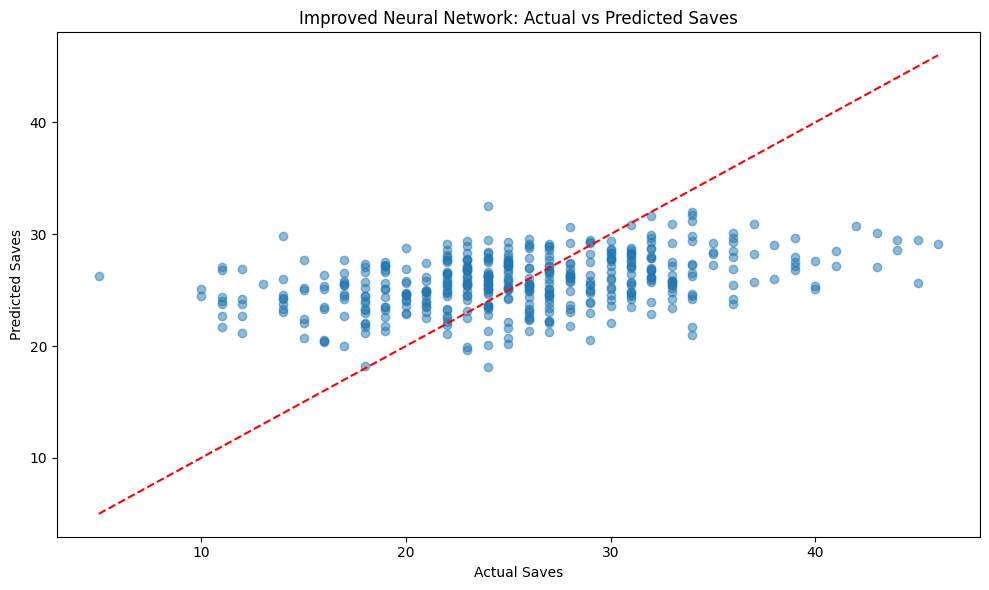

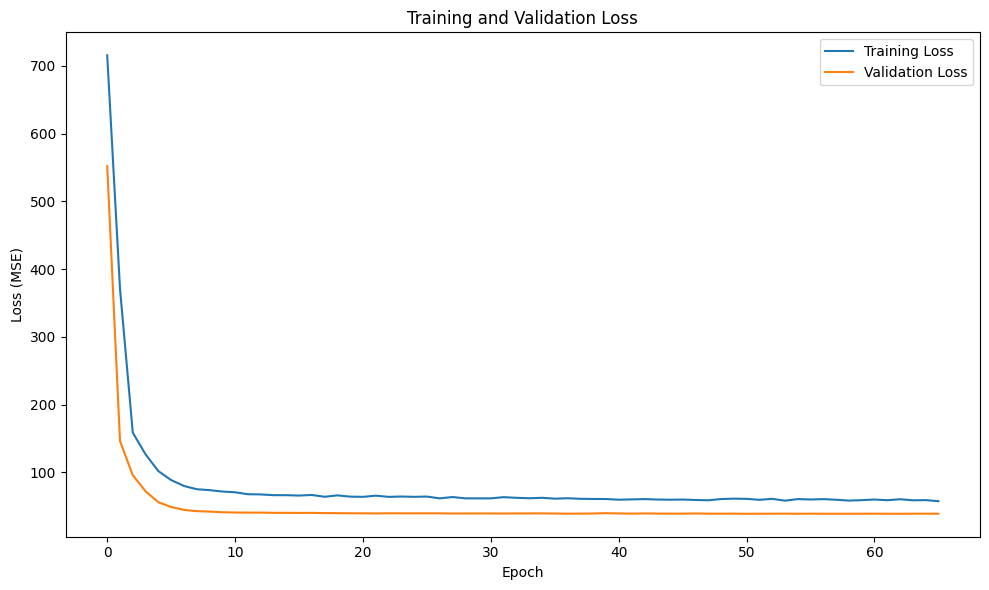


===== Improved Neural Network Model Evaluation =====
R² Score: 0.1598
Mean Absolute Error: 4.9517 saves
Root Mean Squared Error: 6.2295 saves
Predictions within ±1 saves: 11.21%
Predictions within ±2 saves: 21.30%
Predictions within ±3 saves: 37.00%
Predictions within ±5 saves: 61.21%


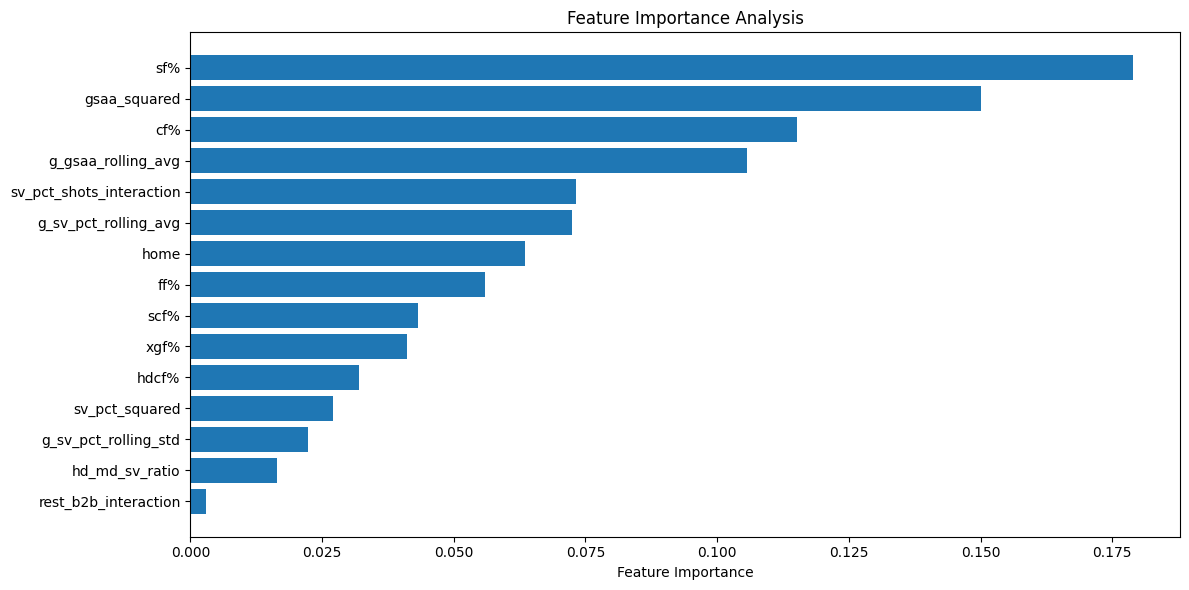

In [17]:


# Define a dataset class for our goalie data
class GoalieDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define a more complex neural network architecture
class GoalieNN(nn.Module):
    def __init__(self, input_size):
        super(GoalieNN, self).__init__()
        # More complex architecture with additional layers
        self.model = nn.Sequential(
            nn.Linear(input_size, 32),  # Larger first hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),  # Add dropout for regularization
            nn.Linear(32, 16),  # Add another hidden layer
            nn.ReLU(),
            nn.Dropout(0.1),  # Add dropout for regularization
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Function to train the model with improved parameters
def train_nn_model_ultrafast(X_train, y_train, X_test, y_test, 
                             batch_size=64, epochs=200, learning_rate=0.001,
                             weight_decay=1e-5, patience=10):
    """
    Ultra-fast training function with improved parameters
    """
    # Start timing
    start_time = time.time()
    
    # Create datasets and dataloaders
    train_dataset = GoalieDataset(X_train, y_train)
    test_dataset = GoalieDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, loss function, and optimizer
    model = GoalieNN(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    # Training loop
    train_losses = []
    val_losses = []
    best_model_state = None
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    print(f"Training neural network for {epochs} epochs...")
    print(f"Progress: [", end="")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Quick validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        
        # Print progress
        print("=", end="", flush=True)
        
        # Print detailed info every few epochs
        if (epoch + 1) % 2 == 0 or epoch == epochs - 1:
            elapsed = time.time() - start_time
            eta = elapsed / (epoch + 1) * (epochs - epoch - 1)
            print(f"] {epoch+1}/{epochs} epochs - {elapsed:.1f}s elapsed, ~{eta:.1f}s remaining")
            print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
            if epoch < epochs - 1:
                print(f"Progress: [", end="")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy().flatten()
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    # Calculate execution time
    execution_time = time.time() - start_time
    print(f"\nTraining completed in {execution_time:.2f} seconds")
    
    return model, y_pred, metrics

# Function to run an improved neural network evaluation
def run_improved_goalie_nn():
    """
    Run an improved version of the neural network model with feature engineering
    """
    # Define base features
    base_features = [
        'home', 'b2b', 'opp_b2b',
        'g_gsaa_rolling_avg', 'g_shots_against_rolling_avg', 'g_shots_against_rolling_std',
        'g_sv_pct_rolling_avg', 'g_sv_pct_rolling_std',
        'g_hdsv_pct_rolling_avg', 'g_mdsv_pct_rolling_avg',
        'g_games_last_7', 'g_days_rest',
        'ff%', 'cf%', 'sf%', 'xgf%', 'hdcf%', 'scf%'
    ]

    # Prepare the data
    X = processed_df[base_features].copy()
    y = processed_df['res_saves']
    
    # Feature engineering - create interaction terms
    X['rest_b2b_interaction'] = X['g_days_rest'] * X['b2b']
    X['sv_pct_shots_interaction'] = X['g_sv_pct_rolling_avg'] * X['g_shots_against_rolling_avg']
    X['home_sv_pct_interaction'] = X['home'] * X['g_sv_pct_rolling_avg']
    
    # Create polynomial features for key metrics
    X['gsaa_squared'] = X['g_gsaa_rolling_avg'] ** 2
    X['sv_pct_squared'] = X['g_sv_pct_rolling_avg'] ** 2
    
    # Create ratio features
    X['hd_md_sv_ratio'] = X['g_hdsv_pct_rolling_avg'] / X['g_mdsv_pct_rolling_avg'].replace(0, 0.001)
    
    # Handle missing values
    X = X.fillna(X.mean())

    # Define train/test split based on time
    split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)

    # Create train/test sets based on date
    train_mask = processed_df['game_date'] <= split_date
    test_mask = processed_df['game_date'] > split_date

    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = processed_df[train_mask]['res_saves']
    y_test = processed_df[test_mask]['res_saves']

    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Using {X_train.shape[1]} features after engineering")
    
    # Feature selection using mutual information
    from sklearn.feature_selection import SelectKBest, mutual_info_regression
    
    # Select top features (adjust k as needed)
    k = min(15, X_train.shape[1])
    selector = SelectKBest(mutual_info_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    # Get names of selected features
    selected_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_indices].tolist()
    
    print("Selected features:")
    for i, feature in enumerate(selected_features):
        print(f"  {i+1}. {feature}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # Train the neural network with improved settings
    model, y_pred, metrics = train_nn_model_ultrafast(
        X_train_scaled, y_train, X_test_scaled, y_test,
        batch_size=64,
        epochs=200,
        learning_rate=0.001,
        weight_decay=1e-5,
        patience=15
    )
    
    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Improved Neural Network: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(metrics['train_losses'], label='Training Loss')
    plt.plot(metrics['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print("\n===== Improved Neural Network Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = y_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    # Feature importance analysis
    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        feature_importance = model.feature_importances_
    else:
        # For neural networks, use a simple sensitivity analysis
        feature_importance = []
        model.eval()
        with torch.no_grad():
            baseline = model(torch.tensor(X_test_scaled, dtype=torch.float32)).numpy().flatten()
            for i in range(X_test_scaled.shape[1]):
                # Perturb each feature and measure the effect
                X_perturbed = X_test_scaled.copy()
                X_perturbed[:, i] += 0.1 * X_perturbed[:, i].std()
                perturbed = model(torch.tensor(X_perturbed, dtype=torch.float32)).numpy().flatten()
                importance = np.mean(np.abs(perturbed - baseline))
                feature_importance.append(importance)
        
        # Normalize importances
        feature_importance = np.array(feature_importance) / sum(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [selected_features[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Analysis')
    plt.tight_layout()
    plt.show()
    
    return model, scaler, metrics, selected_features

# Run the improved neural network model
improved_nn_model, improved_nn_scaler, improved_nn_metrics, selected_features = run_improved_goalie_nn()